<a href="https://colab.research.google.com/github/carlmaps/Visualizaion-Projects/blob/master/COVID19_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is simple visualiztion project on the covid 19 dataset. <br>
Datasource: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

Import the needed libraries for this project. 

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline

init_notebook_mode(connected=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Some plots below used plotly. If you are you are using Google Colab  make sure to set the renderers default is set to colab so that plots will display. By default it is not set to colab. 

In [0]:
import plotly.io as pio
pio.renderers

#set renderers default to colab if it is not the default
pio.renderers.default = 'colab'

#### Load the Dataset <br>
You can download the dataset from github through colab by using the kaggle API. In my case, I've kept a copy in my drive and mounted my google drive for this project.

In [0]:
covid19 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid_19_data.csv', parse_dates=['ObservationDate'])

#### Dataset Preprocessing

In [0]:
#inspect the columns
covid19.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

#### Rename Columns

In [0]:
covid19 = covid19.rename(columns={'Country/Region':'Country'})
covid19 = covid19.rename(columns={'Province/State':'State'})
covid19 = covid19.rename(columns={'ObservationDate':'Date'})
covid19 = covid19.rename(columns={'Last Update':'LastUpdate'})

#### Checking the datatypes of the columns

In [0]:
covid19.dtypes

SNo                    int64
Date          datetime64[ns]
State                 object
Country               object
LastUpdate            object
Confirmed            float64
Deaths               float64
Recovered            float64
dtype: object

In [0]:
#Convert the LastUpdate to datetime 
covid19['LastUpdate'] = pd.to_datetime(covid19['LastUpdate'])

In [0]:
#Convert float to integer
float_cols = ['Confirmed','Deaths', 'Recovered']
for cols in list(float_cols):
  covid19[cols] = covid19[cols].astype('int64')

covid19.dtypes

SNo                    int64
Date          datetime64[ns]
State                 object
Country               object
LastUpdate    datetime64[ns]
Confirmed              int64
Deaths                 int64
Recovered              int64
dtype: object

In [0]:
covid19.head()

,SNo,Date,State,Country,LastUpdate,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1,0,0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14,0,0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6,0,0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1,0,0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0,0,0


In [0]:
covid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13850 entries, 0 to 13849
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SNo         13850 non-null  int64         
 1   Date        13850 non-null  datetime64[ns]
 2   State       7107 non-null   object        
 3   Country     13850 non-null  object        
 4   LastUpdate  13850 non-null  datetime64[ns]
 5   Confirmed   13850 non-null  int64         
 6   Deaths      13850 non-null  int64         
 7   Recovered   13850 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 865.8+ KB


In [0]:
covid19.isna().sum()

SNo              0
Date             0
State         6743
Country          0
LastUpdate       0
Confirmed        0
Deaths           0
Recovered        0
dtype: int64

Observations:
1. Confirmed, Deaths, and Recovered are of type float. 
1. There are missing values from the 'State' columns'
2. 6562 rows are missing

##### Removing the ship case data and storing it on a different dataframe

In [0]:
shipRow = covid19['Country'].str.contains('MS Zaandam') | covid19['Country'].str.contains('Diamond Princess') | covid19['State'].str.contains('Grand Princess')
ship = covid19[shipRow]
ship.head()

,SNo,Date,State,Country,LastUpdate,Confirmed,Deaths,Recovered
3836,3837,2020-03-07,Grand Princess Cruise Ship,US,2020-03-07 01:33:02,21,0,0
4067,4068,2020-03-08,Grand Princess Cruise Ship,US,2020-03-07 01:33:02,21,0,0
4323,4324,2020-03-09,Grand Princess Cruise Ship,US,2020-03-07 01:33:02,21,0,0
4595,4596,2020-03-10,Grand Princess,US,2020-03-10 02:33:04,21,0,0
4809,4810,2020-03-11,Grand Princess,US,2020-03-10 02:33:04,21,0,0


In [0]:
covid19 = covid19[~(shipRow)]

In [0]:
ship_latest = ship[ship['Date']==max(ship['Date'])]
ship_latest

,SNo,Date,State,Country,LastUpdate,Confirmed,Deaths,Recovered
13572,13573,2020-04-10,NaN,Diamond Princess,2020-04-10 23:01:43,712,11,619
13627,13628,2020-04-10,NaN,MS Zaandam,2020-04-10 23:01:43,9,2,0
13744,13745,2020-04-10,Grand Princess,Canada,2020-04-10 23:01:43,13,0,0
13745,13746,2020-04-10,Grand Princess,US,2020-04-10 23:01:43,103,3,0


In [0]:
covid_data = covid19.drop(['SNo','LastUpdate', 'State'], axis=1)
covid_data['Cases'] = covid_data[['Confirmed', 'Recovered', 'Deaths']].sum(axis=1)
covid_data.head()

,Date,Country,Confirmed,Deaths,Recovered,Cases
0,2020-01-22,Mainland China,1,0,0,1
1,2020-01-22,Mainland China,14,0,0,14
2,2020-01-22,Mainland China,6,0,0,6
3,2020-01-22,Mainland China,1,0,0,1
4,2020-01-22,Mainland China,0,0,0,0


#### Visualization using Matplotlib
Areaplot of the COVID19 case. This shows the total confirmed, deaths and recovered case in general

In [0]:
covid_top20 = covid_data.groupby(['Date'])['Confirmed', 'Recovered', 'Deaths','Cases'].sum().reset_index()
covid_top20 = covid_top20.melt(id_vars='Date', value_vars=['Confirmed', 'Recovered', 'Deaths'],
                 var_name='Case', value_name='Count')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [0]:
covid_top20 = covid_top20.pivot(index='Date', columns='Case',values='Count').reset_index()
covid_top20.set_index(['Date'], inplace=True)

In [0]:
covid_top20.columns

Index(['Confirmed', 'Deaths', 'Recovered'], dtype='object', name='Case')

Text(2020-01-23 00:00:00, 1790882, 'Includes Current Cases, Recoveries, and Deaths')

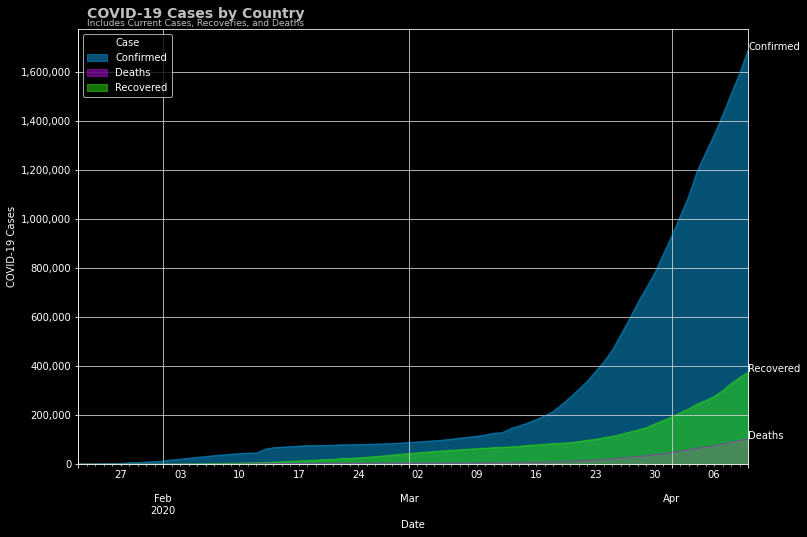

In [0]:
plt.style.use('dark_background')
colors = {'Confirmed':'#08a2e7', 'Deaths':'#bd08e7', 'Recovered':'#32e708'}
plot = covid_top20.plot(figsize=(12,8), linewidth=1, legend=True,kind='area', stacked=False, color=list(colors.values()))
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('COVID-19 Cases')

for case in list(covid_top20.columns):
  plot.text(x = covid_top20.index[-1], y = covid_top20[case].max(), s = case, weight = 'normal')

plot.text(x = covid_top20.index[1], y = int(covid_top20.max().max())+130000, s = "COVID-19 Cases by Country", fontsize = 14, weight = 'bold', alpha = .75)
plot.text(x = covid_top20.index[1], y = int(covid_top20.max().max())+100000, s = "Includes Current Cases, Recoveries, and Deaths", fontsize = 9, alpha = .75)

In [0]:
covid19_top_countries = covid_data.groupby(['Date','Country'])['Confirmed', 'Recovered', 'Deaths','Cases'].sum().reset_index()
countries10 = covid19_top_countries[covid19_top_countries['Date'] == covid19_top_countries['Date'].max()].groupby(['Country']).sum().reset_index().sort_values('Cases', ascending=False).iloc[:10]['Country']
countries20 = covid19_top_countries[covid19_top_countries['Date'] == covid19_top_countries['Date'].max()].groupby(['Country']).sum().reset_index().sort_values('Cases', ascending=False).iloc[:20]['Country']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [0]:
covid19_top10_countries = covid19_top_countries[covid19_top_countries['Country'].isin(countries10)]
covid19_top20_countries = covid19_top_countries[covid19_top_countries['Country'].isin(countries20)]

In [0]:
covid19_top10_countries = covid19_top10_countries.pivot(index='Date', columns='Country', values='Cases').reset_index()

In [0]:
covid19_top10_countries.set_index(['Date'], inplace=True)
covid19_top10_countries = covid19_top10_countries.fillna(0)

In [0]:
#coverting float to int64 after during the pivot
float_cols = covid19_top10_countries.columns
for cols in list(float_cols):
  covid19_top10_countries[cols] = covid19_top10_countries[cols].astype('int64')

#### Creating the Line Plot for the Top 10 Countries with highest cases

Text(2020-01-23 00:00:00, 573805, 'Includes Current Cases, Recoveries, and Deaths')

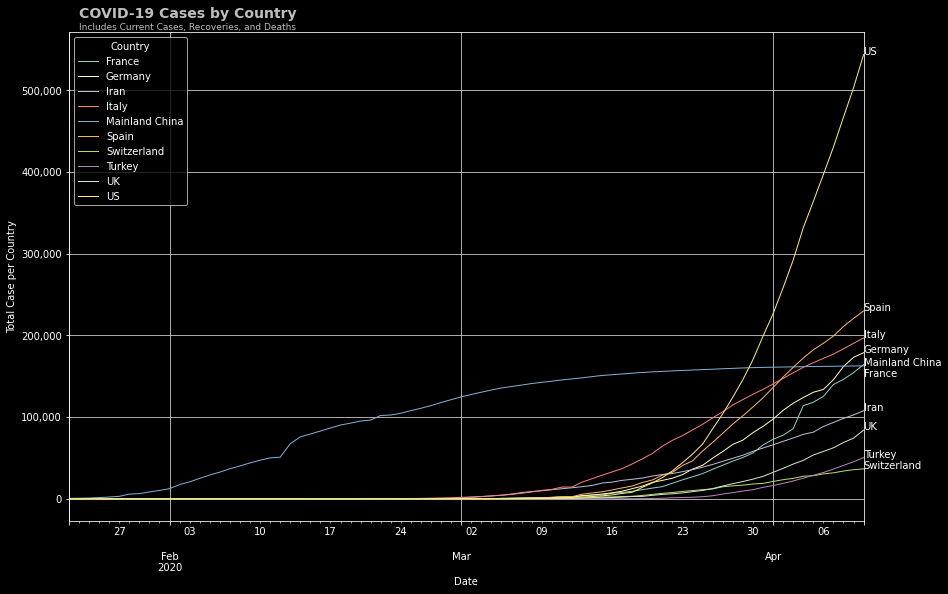

In [0]:
plt.style.use('dark_background')
plot = covid19_top10_countries.plot(figsize=(12,8), linewidth=1, legend=True)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('Total Case per Country')

for country in list(countries10.values):
    if(country == 'France'):
      plot.text(x = covid19_top10_countries.index[-1], y = covid19_top10_countries[country].max()-15000, s = country, weight = 'normal')
    else:
      plot.text(x = covid19_top10_countries.index[-1], y = covid19_top10_countries[country].max(), s = country, weight = 'normal')

plot.text(x = covid19_top10_countries.index[1], y = int(covid19_top10_countries.max().max())+45000, s = "COVID-19 Cases by Country", fontsize = 14, weight = 'bold', alpha = .75)
plot.text(x = covid19_top10_countries.index[1], y = int(covid19_top10_countries.max().max())+30000, s = "Includes Current Cases, Recoveries, and Deaths", fontsize = 9, alpha = .75)

In [0]:
#Getting the total confirmed cases for the top 20 Countries
total_confirmed_perCountry = []
for i in range(len(countries20)):
  #print(countries20.iloc[i])
  count = 0
  temp = covid19_top20_countries[covid19_top20_countries['Country'] == countries20.iloc[i]]
  count += temp.sort_values('Date').iloc[-1]['Confirmed']
  total_confirmed_perCountry.append(count)

#Getting the total death cases for the top 20 Countries
total_deaths_perCountry = []
for i in range(len(countries20)):
  #print(countries20.iloc[i])
  count = 0
  temp = covid19_top20_countries[covid19_top20_countries['Country'] == countries20.iloc[i]]
  count += temp.sort_values('Date').iloc[-1]['Deaths']
  total_deaths_perCountry.append(count)

#Getting the total recovered cases for the top 20 Countries
total_recovered_perCountry = []
for i in range(len(countries20)):
  #print(countries20.iloc[i])
  count = 0
  temp = covid19_top20_countries[covid19_top20_countries['Country'] == countries20.iloc[i]]
  count += temp.sort_values('Date').iloc[-1]['Recovered']
  total_recovered_perCountry.append(count)


In [0]:
#Create the dataframe to be used for the next visualization plot
covid_cases_top_20 = pd.DataFrame(columns=['Country','Confirmed','Deaths','Recovered'],index=None)
covid_cases_top_20.Country = countries20
covid_cases_top_20.Confirmed = total_confirmed_perCountry
covid_cases_top_20.Deaths = total_deaths_perCountry
covid_cases_top_20.Recovered = total_recovered_perCountry

Crating the horizontal bar plot for the top 20 countries with highest COVID19 cases

In [0]:
plt.style.use('dark_background')
fig_confirmed = px.bar(covid_cases_top_20.sort_values('Confirmed').tail(20), x='Confirmed', y='Country', template="plotly_dark",
                text='Confirmed', orientation='h', color_discrete_sequence=px.colors.qualitative.Alphabet)

fig_confirmed.update_layout(
    title_text = 'Top 20 Countries with Most Confirmed Cases',
    title_x = 0.5,  
    )
#fig_confirmed.show()

In [0]:
plt.style.use('dark_background')
fig_confirmed = px.bar(covid_cases_top_20.sort_values('Deaths').tail(20), x='Deaths', y='Country', template="plotly_dark",
                text='Deaths', orientation='h', color_discrete_sequence=px.colors.qualitative.Alphabet)

fig_confirmed.update_layout(
    title_text = 'Death Count for the Top 20 Countries with confirmed cases',
    title_x = 0.5,  
    )

In [0]:
plt.style.use('dark_background')
fig_confirmed = px.bar(covid_cases_top_20.sort_values('Recovered').tail(20), x='Recovered', y='Country', template="plotly_dark",
                text='Recovered', orientation='h', color_discrete_sequence=px.colors.qualitative.Alphabet)

fig_confirmed.update_layout(
    title_text = 'Recovered Count for the Top 20 Countries with confirmed cases',
    title_x = 0.5,  
    )

#### Geospatial Plot using Plotly Choropleth


In [0]:
df_countries = covid19.groupby(['Country', 'Date']).sum().reset_index().sort_values('Date', ascending=False)
df_countries = df_countries.drop_duplicates(subset = ['Country'])
df_countries = df_countries[df_countries['Confirmed']>0]

In [0]:
fig = go.Figure(data=go.Choropleth(
    locations = df_countries['Country'],
    locationmode = 'country names',
    z = df_countries['Confirmed'],
    colorscale = 'Reds',
    marker_line_color = 'black',
    marker_line_width = 0.5,
    
))

fig.update_layout(
    title_text = 'Confirmed Cases as of April 10, 2020',
    title_x = 0.5,
    template="plotly_dark",
    geo=dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)

fig.show()

In [0]:
# Manipulating the original dataframe
df_countrydate = covid19[covid19['Confirmed']>0]
df_countrydate = df_countrydate.groupby(['Date','Country']).sum().reset_index()
#covert back the Date to object to avoid any errors in plotting since animation_from is the date and it requires to pass as a string
df_countrydate['Date'] = df_countrydate['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# Creating the visualization
fig = px.choropleth(df_countrydate, 
                    locations="Country", 
                    locationmode = "country names",
                    color="Confirmed", 
                    hover_name="Country", 
                    animation_frame="Date"

                   )
fig.update_layout(
    title_text = 'Global Spread of Coronavirus Data as of April 10, 2020',
    title_x = 0.5,
    template="plotly_dark",
    geo=dict(
        showframe = False,
        showcoastlines = False,
    ))